# Variational Autoencoder (VAE)

Useful links:
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset [http://vis-www.cs.umass.edu/lfw/](http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [3]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.initializers as I
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# The following code fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
import numpy as np
import os
from cv2 import imread, resize
import pandas as pd

def fetch_lfw_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      raw_images_name = "lfw",
                      use_raw=False,
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ):#sad smile

    #download if not exists
    if (not use_raw) and not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if use_raw and not os.path.exists(raw_images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(raw_images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s"%attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    df_attrs.imagenum = df_attrs.imagenum.astype(np.int64)


    #read photos
    dirname = raw_images_name if use_raw else images_name
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(dirname):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos = df['photo_path'].apply(imread)\
                                 .apply(lambda img: img[dy:-dy,dx:-dx])\
                                 .apply(lambda img: resize(img, (dimx, dimy)))

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos,all_attrs
data, attrs = fetch_lfw_dataset()

In [6]:
print(attrs.shape)
print(data.shape)
attrs.head()

(13143, 73)
(13143, 45, 45, 3)


,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,-1.273512,-1.431462,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,-1.889111,-1.857213,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.08268,-0.439614,-0.359859,-0.760774,-0.410152


In [7]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [8]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [9]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

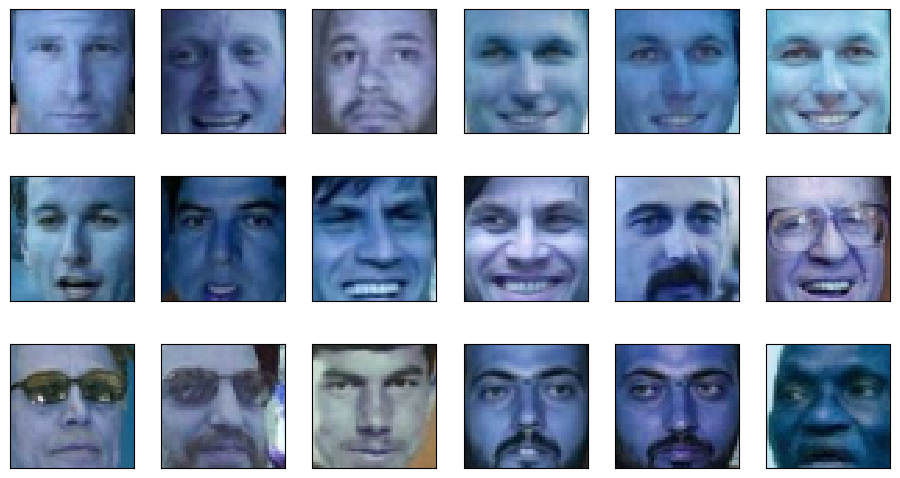

In [10]:
plot_gallery(X_train, image_h, image_w)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:


<img src="/content/Autoencoder_structure.jpg">

In [11]:
dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?

# You can define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

# However, you can just have 1 fc layer in each network without any activation,
# and it will also show some results

vanila_encoder = tf.keras.Sequential()
vanila_encoder.add(L.Dense(4*dimZ, activation='relu', kernel_initializer=I.GlorotUniform()))
vanila_encoder.add(L.Dense(dimZ, kernel_initializer=I.GlorotUniform()))
vanila_decoder = tf.keras.Sequential()
vanila_decoder.add(L.Dense(4*dimZ, activation='relu', kernel_initializer=I.GlorotUniform()))
vanila_decoder.add(L.Dense(X_train.shape[1], activation='sigmoid', kernel_initializer=I.GlorotUniform()))

model = tf.keras.Sequential()
model.add(vanila_encoder)
model.add(vanila_decoder)

In [12]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, rate):
        super(DisplayCallback, self).__init__()
        self.model = model
        self.rate = rate

    def on_epoch_end(self, epoch, logs=None):
        model = self.model
        if epoch % self.rate == 0:
            idx = np.random.choice(X_train.shape[0])
            plt.subplot(221)
            plt.imshow(X_train[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(222)
            plt.imshow(tf.reshape(
                model(X_train[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            idx = np.random.choice(X_val.shape[0])
            plt.subplot(223)
            plt.imshow(X_val[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(224)
            plt.imshow(tf.reshape(
                model(X_val[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            plt.show()

In [13]:
# Create MSE loss function
loss = tf.keras.losses.mean_squared_error
# Use Adam optimizer
opt = tf.keras.optimizers.Adam()
model.compile(loss=loss, optimizer=opt)
callback = DisplayCallback(model, 10)

In [14]:
model.build(input_shape=X_train.shape)

Epoch 1/30
312/313 [============================>.] - ETA: 0s - loss: 0.0174

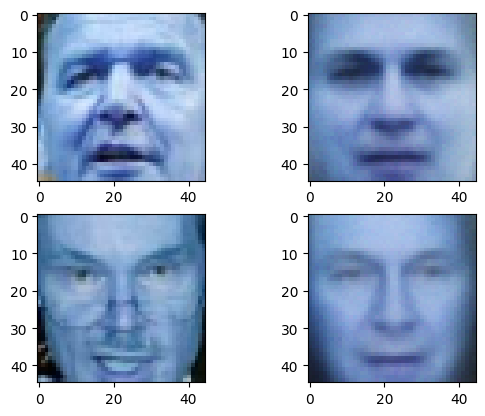

313/313 [==============================] - 8s 8ms/step - loss: 0.0174 - val_loss: 0.0126
Epoch 2/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0115 - val_loss: 0.0099
Epoch 3/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0077
Epoch 4/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0068 - val_loss: 0.0062
Epoch 5/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 6/30
313/313 [==============================] - 1s 4ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 7/30
313/313 [==============================] - 1s 4ms/step - loss: 0.0054 - val_loss: 0.0058
Epoch 8/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 9/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 10/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 11/3

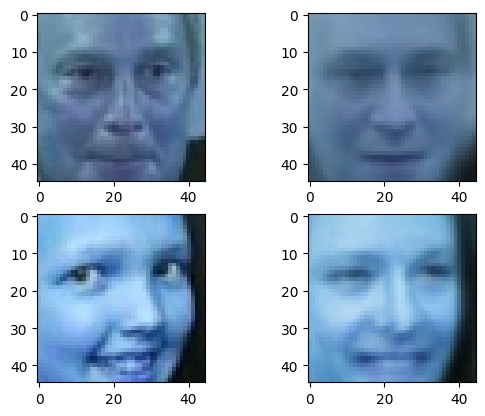

313/313 [==============================] - 2s 7ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 12/30
313/313 [==============================] - 3s 8ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 13/30
313/313 [==============================] - 2s 8ms/step - loss: 0.0046 - val_loss: 0.0049
Epoch 14/30
313/313 [==============================] - 2s 7ms/step - loss: 0.0045 - val_loss: 0.0050
Epoch 15/30
313/313 [==============================] - 3s 10ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 16/30
313/313 [==============================] - 2s 8ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 17/30
313/313 [==============================] - 3s 9ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 18/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 19/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 20/30
313/313 [==============================] - 3s 9ms/step - loss: 0.0043 - val_loss: 0.0047
E

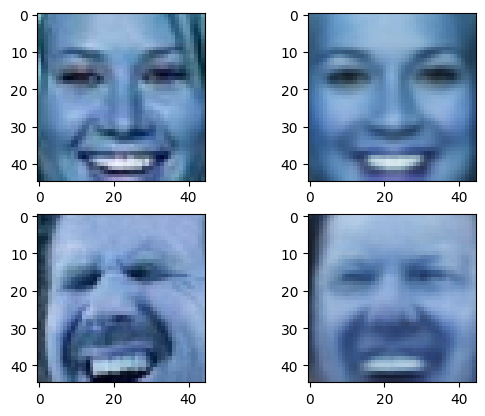

313/313 [==============================] - 3s 11ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 22/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0042 - val_loss: 0.0045
Epoch 23/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 24/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0043 - val_loss: 0.0047
Epoch 25/30
313/313 [==============================] - 1s 4ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 26/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 27/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0042 - val_loss: 0.0045
Epoch 28/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 29/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 30/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0041 - val_loss: 0.0047


In [15]:
# Train your autoencoder
# Add validation data
# Visualize progress in reconstruction and loss decay
history = model.fit(
    X_train, X_train,
    epochs=30,
    validation_data = (X_val, X_val),
    callbacks=[callback]
)

Plot your loss values (also metrics, if you used them) for train and validation data

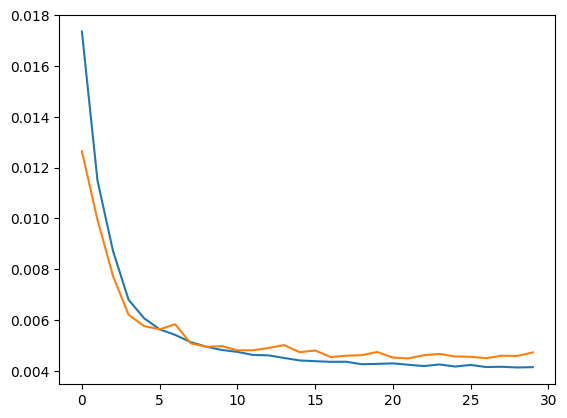

In [16]:
plt.plot(np.arange(30), history.history['loss'])
plt.plot(np.arange(30), history.history['val_loss'])
plt.show()

# Sampling



```
# This is formatted as code
```

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

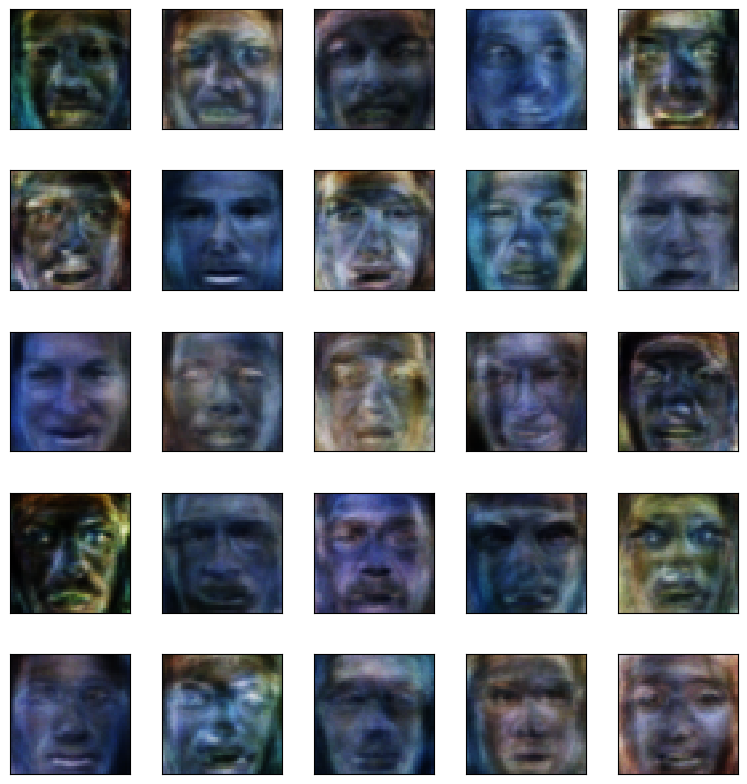

In [18]:
z = np.random.randn(25, dimZ)
output = vanila_decoder(z).numpy()
plot_gallery(output, image_h, image_w, n_row=5, n_col=5)

# Homework: Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler**, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [17]:
dimZ = 100

# define the network
# you can start from pytorch example https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

#encoder = tf.keras.Model(, []) # output should be mean, variance and a sample

#decoder = tf.keras.Model(, )
# Encoder Model
encoder_input = tf.keras.Input(shape=(X_train.shape[1],))
enc_hidden = L.Dense(4*dimZ, activation='relu', kernel_initializer=I.GlorotUniform())(encoder_input)
mu = L.Dense(dimZ, kernel_initializer=I.GlorotUniform())(enc_hidden)
log_var = L.Dense(dimZ, kernel_initializer=I.GlorotUniform())(enc_hidden)

# Gaussian sampler
def gaussian_sampler(args):
    mu, log_var = args
    epsilon = tf.random.normal(shape=tf.shape(mu))
    z = mu + tf.exp(0.5 * log_var) * epsilon
    return z

# Reparameterization
encoder_output = L.Lambda(gaussian_sampler)([mu, log_var])
encoder = tf.keras.Model(inputs=encoder_input, outputs=[mu, log_var, encoder_output])

# Decoder Model
decoder_input = tf.keras.Input(shape=(dimZ,))
dec_hidden = L.Dense(4*dimZ, activation='relu', kernel_initializer=I.GlorotUniform())(decoder_input)
output_mean = L.Dense(X_train.shape[1], activation='sigmoid', kernel_initializer=I.GlorotUniform())(dec_hidden)
output_log_var = L.Dense(X_train.shape[1], kernel_initializer=I.GlorotUniform())(dec_hidden)
decoder_output = L.Lambda(gaussian_sampler)([output_mean, output_log_var])
decoder = tf.keras.Model(inputs=decoder_input, outputs=[output_mean, output_log_var, decoder_output])

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

In [19]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    @tf.function
    def KL_divergence(self, mu, logsigma):
        kl_loss = -0.5 * tf.reduce_sum(1 + logsigma - tf.square(mu) - tf.exp(logsigma), axis=-1)
        return tf.reduce_mean(kl_loss)

    @tf.function
    def log_likelihood(self, x, z):
        recon_loss = tf.reduce_sum(tf.square(x - z), axis=-1)
        return tf.reduce_mean(recon_loss)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            mu, logsigma, z = self.encoder(data)
            recon_mean, recon_log_var, reconstruction = self.decoder(z)

            kl_loss = self.KL_divergence(mu, logsigma)
            recon_loss = self.log_likelihood(data, reconstruction)
            total_loss = kl_loss + recon_loss

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {
            "total_loss": total_loss,
            "kl_loss": kl_loss,
            "recon_loss": recon_loss,
        }

    def call(self, inputs):
        mu, logsigma, z = self.encoder(inputs)
        _, _, reconstruction = self.decoder(z)
        return reconstruction


In [20]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
callback = DisplayCallback(vae, 2)

And train the model:

In [23]:
history = vae.fit(X_train, epochs=30, validation_data=(X_val, None))

Epoch 1/30
313/313 [==============================] - 4s 6ms/step - total_loss: 283.5405 - kl_loss: 65.4861 - recon_loss: 218.0544 - val_loss: 0.0000e+00
Epoch 2/30
313/313 [==============================] - 2s 5ms/step - total_loss: 128.5002 - kl_loss: 22.6346 - recon_loss: 105.8657 - val_loss: 0.0000e+00
Epoch 3/30
313/313 [==============================] - 2s 5ms/step - total_loss: 115.7336 - kl_loss: 22.3765 - recon_loss: 93.3572 - val_loss: 0.0000e+00
Epoch 4/30
313/313 [==============================] - 2s 7ms/step - total_loss: 104.8554 - kl_loss: 21.2790 - recon_loss: 83.5765 - val_loss: 0.0000e+00
Epoch 5/30
313/313 [==============================] - 2s 5ms/step - total_loss: 96.3055 - kl_loss: 19.9980 - recon_loss: 76.3075 - val_loss: 0.0000e+00
Epoch 6/30
313/313 [==============================] - 2s 5ms/step - total_loss: 92.2128 - kl_loss: 19.3254 - recon_loss: 72.8874 - val_loss: 0.0000e+00
Epoch 7/30
313/313 [==============================] - 2s 5ms/step - total_loss: 87

Plot the learning curves

And finally sample from VAE.

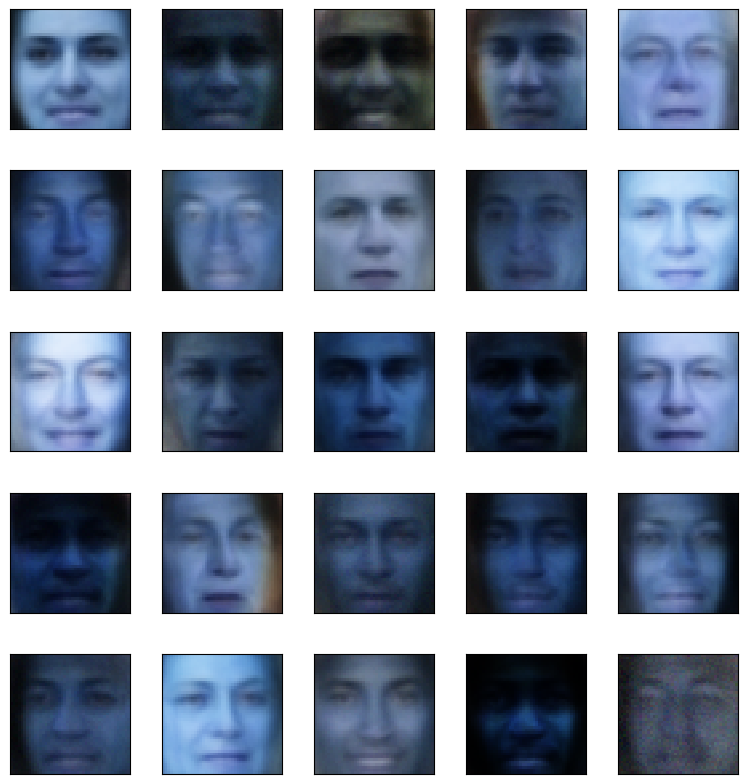

In [27]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))
num_samples = 25

z_samples = tf.random.normal(shape=(num_samples, dimZ))
_, _, generated_images = vae.decoder(z_samples)
plot_gallery(generated_images, image_h, image_w, n_row=5, n_col=5)


In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it.

# Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE.

<img src="linear.png" alt="linear">

In [ ]:
# your code here

Vanila autoencoders are not suitable for this task